In [28]:
%cd /kaggle/input/6998projectdata/
# %ls /kaggle/input/


/kaggle/input/6998projectdata


In [6]:
%ls

click_original.csv


In [7]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import VarianceScaling
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import numpy as np
from sklearn.metrics import roc_curve,auc,precision_recall_curve,roc_curve
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import collections


import matplotlib.pyplot as plt


In [8]:
"""
Multi-gate Mixture-of-Experts model implementation.

Copyright (c) 2018 Drawbridge, Inc
Licensed under the MIT License (see LICENSE for details)
Written by Alvin Deng
"""

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import activations, initializers, regularizers, constraints
from tensorflow.keras.layers import Layer, InputSpec


class MMoE(Layer):
    """
    Multi-gate Mixture-of-Experts model.
    """

    def __init__(self,
                 units,
                 num_experts,
                 num_tasks,
                 use_expert_bias=True,
                 use_gate_bias=True,
                 expert_activation='relu',
                 gate_activation='softmax',
                 expert_bias_initializer='zeros',
                 gate_bias_initializer='zeros',
                 expert_bias_regularizer=None,
                 gate_bias_regularizer=None,
                 expert_bias_constraint=None,
                 gate_bias_constraint=None,
                 expert_kernel_initializer='VarianceScaling',
                 gate_kernel_initializer='VarianceScaling',
                 expert_kernel_regularizer=None,
                 gate_kernel_regularizer=None,
                 expert_kernel_constraint=None,
                 gate_kernel_constraint=None,
                 activity_regularizer=None,
                 **kwargs):
        """
         Method for instantiating MMoE layer.

        :param units: Number of hidden units
        :param num_experts: Number of experts
        :param num_tasks: Number of tasks
        :param use_expert_bias: Boolean to indicate the usage of bias in the expert weights
        :param use_gate_bias: Boolean to indicate the usage of bias in the gate weights
        :param expert_activation: Activation function of the expert weights
        :param gate_activation: Activation function of the gate weights
        :param expert_bias_initializer: Initializer for the expert bias
        :param gate_bias_initializer: Initializer for the gate bias
        :param expert_bias_regularizer: Regularizer for the expert bias
        :param gate_bias_regularizer: Regularizer for the gate bias
        :param expert_bias_constraint: Constraint for the expert bias
        :param gate_bias_constraint: Constraint for the gate bias
        :param expert_kernel_initializer: Initializer for the expert weights
        :param gate_kernel_initializer: Initializer for the gate weights
        :param expert_kernel_regularizer: Regularizer for the expert weights
        :param gate_kernel_regularizer: Regularizer for the gate weights
        :param expert_kernel_constraint: Constraint for the expert weights
        :param gate_kernel_constraint: Constraint for the gate weights
        :param activity_regularizer: Regularizer for the activity
        :param kwargs: Additional keyword arguments for the Layer class
        """
        # Hidden nodes parameter
        self.units = units
        self.num_experts = num_experts
        self.num_tasks = num_tasks

        # Weight parameter
        self.expert_kernels = None
        self.gate_kernels = None
        self.expert_kernel_initializer = initializers.get(expert_kernel_initializer)
        self.gate_kernel_initializer = initializers.get(gate_kernel_initializer)
        self.expert_kernel_regularizer = regularizers.get(expert_kernel_regularizer)
        self.gate_kernel_regularizer = regularizers.get(gate_kernel_regularizer)
        self.expert_kernel_constraint = constraints.get(expert_kernel_constraint)
        self.gate_kernel_constraint = constraints.get(gate_kernel_constraint)

        # Activation parameter
        self.expert_activation = activations.get(expert_activation)
        self.gate_activation = activations.get(gate_activation)

        # Bias parameter
        self.expert_bias = None
        self.gate_bias = None
        self.use_expert_bias = use_expert_bias
        self.use_gate_bias = use_gate_bias
        self.expert_bias_initializer = initializers.get(expert_bias_initializer)
        self.gate_bias_initializer = initializers.get(gate_bias_initializer)
        self.expert_bias_regularizer = regularizers.get(expert_bias_regularizer)
        self.gate_bias_regularizer = regularizers.get(gate_bias_regularizer)
        self.expert_bias_constraint = constraints.get(expert_bias_constraint)
        self.gate_bias_constraint = constraints.get(gate_bias_constraint)

        # Activity parameter
        self.activity_regularizer = regularizers.get(activity_regularizer)

        # Keras parameter
        self.input_spec = InputSpec(min_ndim=2)
        self.supports_masking = True

        super(MMoE, self).__init__(**kwargs)

    def build(self, input_shape):
        """
        Method for creating the layer weights.

        :param input_shape: Keras tensor (future input to layer)
                            or list/tuple of Keras tensors to reference
                            for weight shape computations
        """
        assert input_shape is not None and len(input_shape) >= 2

        input_dimension = input_shape[-1]

        # Initialize expert weights (number of input features * number of units per expert * number of experts)
        self.expert_kernels = self.add_weight(
            name='expert_kernel',
            shape=(input_dimension, self.units, self.num_experts),
            initializer=self.expert_kernel_initializer,
            regularizer=self.expert_kernel_regularizer,
            constraint=self.expert_kernel_constraint,
        )

        # Initialize expert bias (number of units per expert * number of experts)
        if self.use_expert_bias:
            self.expert_bias = self.add_weight(
                name='expert_bias',
                shape=(self.units, self.num_experts),
                initializer=self.expert_bias_initializer,
                regularizer=self.expert_bias_regularizer,
                constraint=self.expert_bias_constraint,
            )

        # Initialize gate weights (number of input features * number of experts * number of tasks)
        self.gate_kernels = [self.add_weight(
            name='gate_kernel_task_{}'.format(i),
            shape=(input_dimension, self.num_experts),
            initializer=self.gate_kernel_initializer,
            regularizer=self.gate_kernel_regularizer,
            constraint=self.gate_kernel_constraint
        ) for i in range(self.num_tasks)]

        # Initialize gate bias (number of experts * number of tasks)
        if self.use_gate_bias:
            self.gate_bias = [self.add_weight(
                name='gate_bias_task_{}'.format(i),
                shape=(self.num_experts,),
                initializer=self.gate_bias_initializer,
                regularizer=self.gate_bias_regularizer,
                constraint=self.gate_bias_constraint
            ) for i in range(self.num_tasks)]

        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dimension})

        super(MMoE, self).build(input_shape)

    def call(self, inputs, **kwargs):
        """
        Method for the forward function of the layer.

        :param inputs: Input tensor
        :param kwargs: Additional keyword arguments for the base method
        :return: A tensor
        """
        gate_outputs = []
        final_outputs = []

        # f_{i}(x) = activation(W_{i} * x + b), where activation is ReLU according to the paper
        expert_outputs = tf.tensordot(a=inputs, b=self.expert_kernels, axes=1)
        # Add the bias term to the expert weights if necessary
        if self.use_expert_bias:
            expert_outputs = K.bias_add(x=expert_outputs, bias=self.expert_bias)
        expert_outputs = self.expert_activation(expert_outputs)

        # g^{k}(x) = activation(W_{gk} * x + b), where activation is softmax according to the paper
        for index, gate_kernel in enumerate(self.gate_kernels):
            gate_output = K.dot(x=inputs, y=gate_kernel)
            # Add the bias term to the gate weights if necessary
            if self.use_gate_bias:
                gate_output = K.bias_add(x=gate_output, bias=self.gate_bias[index])
            gate_output = self.gate_activation(gate_output)
            gate_outputs.append(gate_output)

        # f^{k}(x) = sum_{i=1}^{n}(g^{k}(x)_{i} * f_{i}(x))
        for gate_output in gate_outputs:
            expanded_gate_output = K.expand_dims(gate_output, axis=1)
            weighted_expert_output = expert_outputs * K.repeat_elements(expanded_gate_output, self.units, axis=1)
            final_outputs.append(K.sum(weighted_expert_output, axis=2))

        return final_outputs

    def compute_output_shape(self, input_shape):
        """
        Method for computing the output shape of the MMoE layer.

        :param input_shape: Shape tuple (tuple of integers)
        :return: List of input shape tuple where the size of the list is equal to the number of tasks
        """
        assert input_shape is not None and len(input_shape) >= 2

        output_shape = list(input_shape)
        output_shape[-1] = self.units
        output_shape = tuple(output_shape)

        return [output_shape for _ in range(self.num_tasks)]

    def get_config(self):
        """
        Method for returning the configuration of the MMoE layer.

        :return: Config dictionary
        """
        config = {
            'units': self.units,
            'num_experts': self.num_experts,
            'num_tasks': self.num_tasks,
            'use_expert_bias': self.use_expert_bias,
            'use_gate_bias': self.use_gate_bias,
            'expert_activation': activations.serialize(self.expert_activation),
            'gate_activation': activations.serialize(self.gate_activation),
            'expert_bias_initializer': initializers.serialize(self.expert_bias_initializer),
            'gate_bias_initializer': initializers.serialize(self.gate_bias_initializer),
            'expert_bias_regularizer': regularizers.serialize(self.expert_bias_regularizer),
            'gate_bias_regularizer': regularizers.serialize(self.gate_bias_regularizer),
            'expert_bias_constraint': constraints.serialize(self.expert_bias_constraint),
            'gate_bias_constraint': constraints.serialize(self.gate_bias_constraint),
            'expert_kernel_initializer': initializers.serialize(self.expert_kernel_initializer),
            'gate_kernel_initializer': initializers.serialize(self.gate_kernel_initializer),
            'expert_kernel_regularizer': regularizers.serialize(self.expert_kernel_regularizer),
            'gate_kernel_regularizer': regularizers.serialize(self.gate_kernel_regularizer),
            'expert_kernel_constraint': constraints.serialize(self.expert_kernel_constraint),
            'gate_kernel_constraint': constraints.serialize(self.gate_kernel_constraint),
            'activity_regularizer': regularizers.serialize(self.activity_regularizer)
        }
        base_config = super(MMoE, self).get_config()

        return dict(list(base_config.items()) + list(config.items()))


In [9]:
from tensorflow.python.ops import math_ops
def custom_loss(y_true, y_pred):
    y_true=tf.cast(y_true,tf.float32)
    not_ignore_case=(y_true[:,0]!=-1)

    y_true=y_true[not_ignore_case]
    y_pred=y_pred[not_ignore_case]
    diff = K.square(y_pred- y_true)  #squared difference
    loss = K.mean(diff, axis=-1) #mean over last dimension
    return loss


In [10]:
def filter_label(df,labels, default_value=-1):
    for label in labels:
        if label not in df.columns:
            df[label]=default_value
    return df
    
def get_data(folderpath, labels):
    # build synthetic training data
    dataset_filenemes=os.listdir(folderpath)
    dataset_filenemes=[f for f in dataset_filenemes if os.path.isfile(os.path.join(folderpath,f))]
    print(f"Datasets used : {list(dataset_filenemes)}")
    
    data=pd.read_csv(os.path.join(folderpath,dataset_filenemes[0]))
    data=filter_label(data, labels)
    data=data.fillna(0)
    all_features=list(set(data.columns)-set(labels))
    print(f"All features we used: {all_features if len(all_features)<=10 else all_features[:10]} (at most 10)")
    for i,file_name in enumerate(dataset_filenemes[1:]):
        _data=pd.read_csv(os.path.join(folderpath,file_name))
        _data=_data.fillna(0)
        _data=filter_label(_data, all_features,default_value=0)
        _data=filter_label(_data, labels)
        _data=_data[all_features+labels]

        data=data.append(_data)

    data=data.sample(frac=1)
    return data
    # dataX = np.array(data.drop(labels,axis=1))
    # dataY = np.array(data[labels]).reshape(-1,len(labels))
    # return dataX, dataY

In [11]:

def cus_accuracy(y_true, y_pred):
    y_true=tf.cast(y_true,tf.float32)
    not_ignore_case=(y_true[:,0]!=-1)

    y_true=y_true[not_ignore_case]
    y_pred=y_pred[not_ignore_case]
    
    y_pred=K.round(K.clip(y_pred,0,1))
    return K.cast(K.equal(y_true, y_pred), K.floatx())


shift = 2
def custom_metric(y_true,y_pred):
    diff = K.abs(K.argmax(y_true, axis=-1) - K.argmax(y_pred, axis=-1))
    return K.mean(K.lesser_equal(diff, shift))

def cus_precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [24]:
class mmoe_model():
    def __init__(self, num_features):
        self.num_features=num_features
        
        # num_features = train_X.shape[1]
        
        # Set up the input layer
        input_layer = Input(shape=(num_features,))

        # Set up MMoE layer
        mmoe_layers = MMoE(
            units=16,
            num_experts=8,
            num_tasks=2
        )(input_layer)

        output_layers = []

        output_info = ['y0', 'y1']

        # Build tower layer from MMoE layer
        for index, task_layer in enumerate(mmoe_layers):
            tower_layer = Dense(
                units=8,
                activation='relu',
                kernel_initializer=VarianceScaling())(task_layer)
            output_layer = Dense(
                units=1,
                name=output_info[index],
                activation='linear',
                kernel_initializer=VarianceScaling())(tower_layer)
            output_layers.append(output_layer)

        # Compile model
        model = Model(inputs=[input_layer], outputs=output_layers)
        learning_rates = [1e-4, 1e-3, 1e-2]
        adam_optimizer = Adam(lr=learning_rates[0])
        model.compile(
            # loss={'y0': custom_loss, 'y1': custom_loss},
            loss={'y0': 'mean_squared_error', 'y1': 'mean_squared_error'},
            # loss={'y0': 'binary_crossentropy', 'y1': 'binary_crossentropy'},
            
            optimizer=adam_optimizer,
            metrics=[metrics.mae,cus_accuracy,"accuracy",   tf.keras.metrics.BinaryAccuracy(
    name="binary_accuracy", dtype=None, threshold=0.5)                     ]
        )

        # Print out model architecture summary
        model.summary()

        self.model=model
        print("init done")


    def data_preprocess(self, data, labels):
        data_X = np.array(data.drop(labels,axis=1))
        data_y = np.array(data[labels]).reshape(-1,len(labels))
        dev_data, test_data, dev_label, test_label=train_test_split(data_X,data_y,test_size=0.2)
        train_data, validation_data, train_label, validation_label=train_test_split(dev_data,dev_label,test_size=0.2)

        train_label=[train_label[:,i] for i in range(train_label.shape[1])]

        validation_label=[validation_label[:,i] for i in range(validation_label.shape[1])]

        test_label=[test_label[:,i] for i in range(test_label.shape[1])]

        return (train_data, train_label), (validation_data, validation_label), (test_data, test_label)
    
    def train(self, data, labels, plot_list=[], epoches=20, verbose=0):
        train_data, validation_data,test_data=self.data_preprocess(data,labels)
        
        train_X,train_y=train_data
        validation_X,validation_y=validation_data
        test_X,test_y=test_data
       

        print('Training data shape = {}'.format(train_X.shape))
        print('Validation data shape = {}'.format(validation_X.shape))
        print('Test data shape = {}'.format(test_X.shape))

        
        # Train the model
        history=self.model.fit(
            x=train_X,
            y=train_y,
            validation_data=(validation_X, validation_y),
            epochs=epoches,
            verbose=verbose,
            batch_size=2024
        )

        if plot_list:
            self.plot_result(history,plot_list,test_X,test_y)
            
        # if val_data:
        #     val_X,val_y=val_data
            



    def plot_result(self, history, plot_list, test_X,test_y):
        plot_num=len(plot_list)
        plt.subplots(plot_num,figsize = (10,6*plot_num))
        
        pid=1
        plt.subplot(plot_num,1,pid)
        plt.plot(history.history['y0_loss'], color = 'blue', label = 'y0_train_loss')
        plt.plot(history.history['y1_loss'], color = 'green', label = 'y1_train_loss')
        plt.plot(history.history['val_y0_loss'], color = 'orange', label = 'y0_val_loss')
        plt.plot(history.history['val_y1_loss'], color = 'red', label = 'y1_val_loss')
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("MMoe Train result - Loss(mse)")
        plt.legend()
        
        if "accuracy" in plot_list:
            pid+=1
            plt.subplot(plot_num,1,pid)
            plt.plot(history.history['y0_cus_accuracy'], color = 'blue', label = 'y0_train_accuracy')
            plt.plot(history.history['y1_cus_accuracy'], color = 'green', label = 'y1_train_accuracy')
            
            plt.plot(history.history['val_y0_cus_accuracy'], color = 'orange', label = 'y0_val_accuracy')
            plt.plot(history.history['val_y1_cus_accuracy'], color = 'red', label = 'y1_val_accuracy')
            
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.title("MMoe Train result - Accuracy")
            plt.legend()
        
        if "auc" in plot_list:
            pid+=1
            plt.subplot(plot_num,1,pid)
            
            y_pred=self.model.predict(test_X)
            FPR1,TPR1,threshold=roc_curve(test_y[0].reshape(-1),y_pred[0].reshape(-1),pos_label=1)
            FPR2,TPR2,threshold=roc_curve(test_y[1].reshape(-1),y_pred[1].reshape(-1),pos_label=1)
            AUC1=auc(FPR1,TPR1)
            AUC2=auc(FPR2,TPR2)

            plt.title(f'ROC CURVE (AUC= class 1:{AUC1:.2f}, class 2: {AUC2:.2f})')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.xlim([0.0,1.0])
            plt.ylim([0.0,1.0])
            plt.plot(FPR1,TPR1,label="class 1")
            plt.plot(FPR2,TPR2,label="class 2")
            plt.plot([0, 1], [0, 1], color='m', linestyle='--')
            plt.legend()
            
        if "pr" in plot_list:
            pid+=1
            plt.subplot(plot_num,1,pid)
            plt.title('PR curve')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.xlim([0.0,1.0])
            plt.ylim([0.0,1.0])            
            
            y_pred=self.model.predict(test_X)
            
            print(test_y)
            for i in range(len(y_pred)):
                y_cur_pred=y_pred[i]
                y_cur_test=test_y[i].reshape(-1)
                
                y_cur_pred=y_cur_pred[y_cur_test!=-1]
                y_cur_test=y_cur_test[y_cur_test!=-1]
                
                print(collections.Counter(list(y_cur_test.reshape(-1))))
                
                precision,recall,thresholds = precision_recall_curve(y_cur_test,y_cur_pred.reshape(-1))
                plt.plot(recall,precision, label=f"class {i+1}")

            plt.legend()

        plt.show()




Datasets used : ['click_original.csv']
All features we used: ['time', 'advertiser_id', 'user_id', 'product_id', 'product_category', 'creative_id', 'ad_id', 'click_times', 'industry'] (at most 10)


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 9)]          0                                            
__________________________________________________________________________________________________
m_mo_e_12 (MMoE)                [(None, 16), (None,  1440        input_13[0][0]                   
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 8)            136         m_mo_e_12[0][0]                  
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 8)            136         m_mo_e_12[0][1]                  
___________________________________________________________________________________________

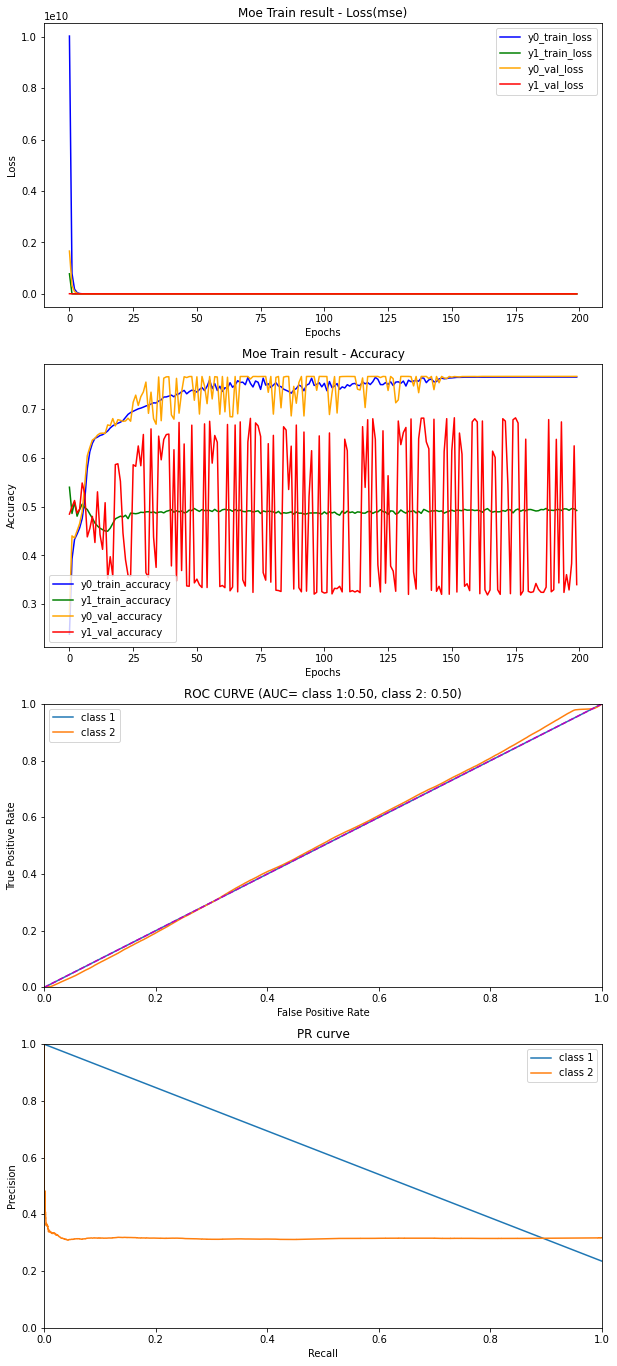

In [30]:
# ['income_50k', 'marital_stat']
# "age","gender"
# "Survived","Pclass"
# 'income_50k', 'marital_stat'
labels=['age', 'gender']
data=get_data("./",labels=labels)
mmm=mmoe_model(data.shape[1]-2)
mmm.train(data,labels, plot_list=["loss","accuracy","auc","pr"],epoches=200,verbose=1)

In [22]:
%cd /kaggle/input/6998projectdata2/
# %ls /kaggle/input/

/kaggle/input/6998projectdata2


Datasets used : ['census-income.csv']
All features we used: ['state_prev_res_ North Carolina', 'state_prev_res_ Louisiana', 'mig_chg_reg_ ?', 'det_ind_code_8', 'det_ind_code_18', 'det_occ_code_42', 'country_mother_ Vietnam', 'country_self_ Yugoslavia', 'det_hh_fam_stat_ Child 18+ never marr Not in a subfamily', 'country_father_ Holand-Netherlands'] (at most 10)


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 499)]        0                                            
__________________________________________________________________________________________________
m_mo_e_9 (MMoE)                 [(None, 16), (None,  72000       input_10[0][0]                   
__________________________________________________________________________________________________
dense_18 (Dense)                (None, 8)            136         m_mo_e_9[0][0]                   
__________________________________________________________________________________________________
dense_19 (Dense)                (None, 8)            136         m_mo_e_9[0][1]                   
____________________________________________________________________________________________

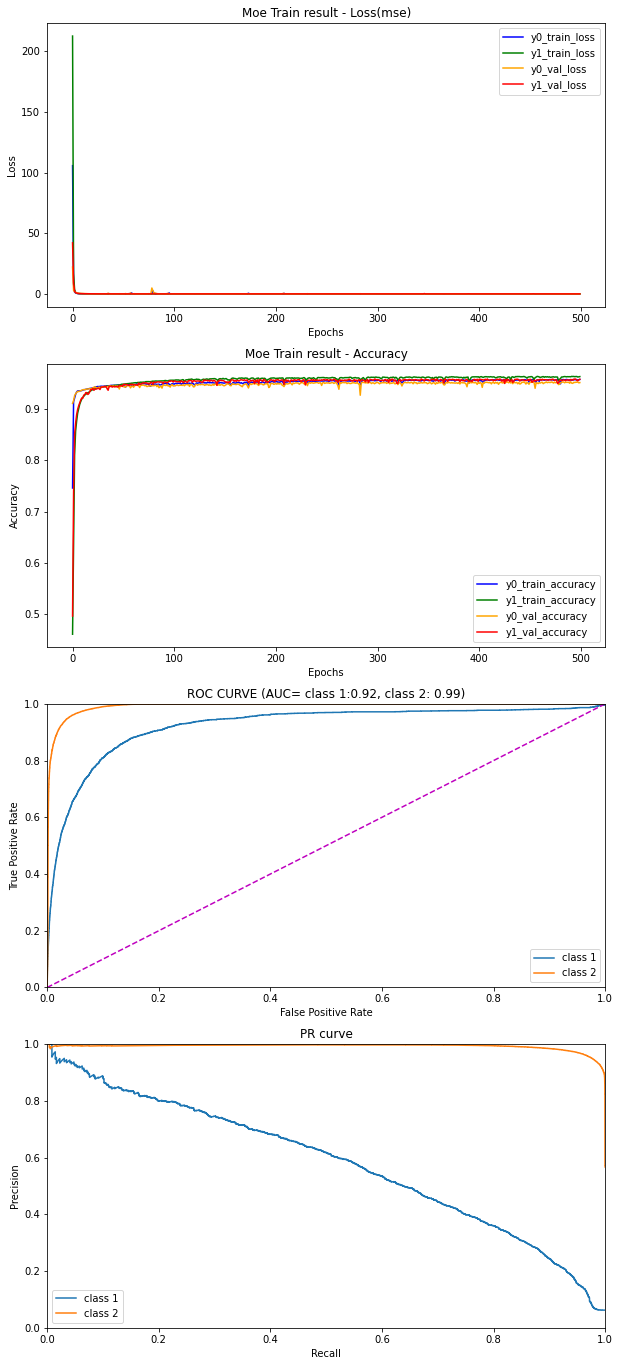

In [26]:
labels=['income_50k', 'marital_stat']
data=get_data("./",labels=labels)
mmm=mmoe_model(data.shape[1]-2)
mmm.train(data,labels, plot_list=["loss","accuracy","auc","pr"],epoches=500,verbose=1)